# Heterogeneous Autoregressive model

The HAR model assumes that the volatility (or other financial variables) is driven by components at different time scales (long-term, medium-term, and short-term).

$$
lnRV_{t+1} = \beta_0 + \beta_1 lnRV_t + \beta_2 lnRV^w_t + \beta_3 lnRV^m_t + \epsilon_t
$$
Where:
- $lnRV_{t+1}$ is the one day ahead forecast of log realised volatility of return.
- $\beta_0, \beta_1, \beta_2, \beta_3$ are the parameters to be estimated.
- $lnRV^w_t$ is the weekly realised variance.
- $lnRV^m_t$ is the monthly realised variance.
- $\epsilon_t$ is the error term.

Flow:
- Load data
- For each lags choice: 

    - Create lags

    - For each forecast horizon: 

        - Split feature and target

        - Split train and test

### Load Data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [13]:
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.rename(columns={'timestamp': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.head(3)

,open,high,low,close,return,RV,lnRV,lnRV_1D_ahead,lnRV_3D_ahead,lnRV_7D_ahead,lnRV_30D_ahead
Date,,,,,,,,,,,
2019-06-23,2.190,2.234,1.800,1.934,-0.125224,0.020962,-3.865058,-3.652501,-3.331801,-4.888673,-4.531543
2019-06-24,1.932,2.020,1.301,1.416,-0.311754,0.025926,-3.652501,-3.161881,-3.956779,-4.830684,-4.813612
2019-06-25,1.417,1.920,1.314,1.540,0.083946,0.042346,-3.161881,-3.331801,-4.305468,-4.114677,-5.343002


### Create Lags

In [8]:
def create_lag(df, lag):
    df_copy = df.copy()
    df_copy[f'lnRV_{lag}D_lag'] = df_copy['lnRV'].rolling(window=lag).mean()
    return df_copy

def create_lags(df, lags):
    for lag in lags:
        df = create_lag(df, lag)
    return df

### Feature & Target Split

In [9]:
def split_f_t(df, horizon):
    df_h = df.copy()
    # drop columns with a different horizon
    df_h.drop(columns=[f'lnRV_{h}D_ahead' for h in [1, 3, 7, 30] if h != horizon], inplace=True)
    df_h.dropna(inplace=True)

    target = df_h.columns[0]
    features = df_h.columns
    features = features[features != target]

    X = df_h[features]
    y = df_h[target]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    return X, y

### Train & Test Split

In [10]:
def split_t_t(X, y):
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

### Prediction

In [11]:
def get_pred(df, lags, h):

    # Create lags
    df = create_lags(df, lags)
    
    # Split the data into features and target
    X, y = split_f_t(df, h)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = split_t_t(X, y)
    print("Train Set starts:", X_train.index[0])
    print("Test Set starts:", X_test.index[0])
    print("Test Set ends:", X_test.index[-1])
    
    # Fit the model
    model = sm.OLS(y_train, X_train).fit()

    # Make predictions
    pred = model.predict(X_test)
    pred = pd.DataFrame(pred, columns=['Pred'])
    pred.index = X_test.index
    
    return pred, y_test

### Plotting

In [ ]:
def plot_pred(pred, actual, h, model):
    plt.figure(figsize=(8, 3))
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.xticks(actual.index[::100])
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(f'{model}{h}D-Ahead Forecast')
    plt.legend()
    plt.savefig(f'../res/{h}D/GARCH-SVM_Actual_vs_Predicted.png')

Train Set starts: 2019-07-14
Test Set starts: 2024-01-13
Test Set ends: 2025-02-27


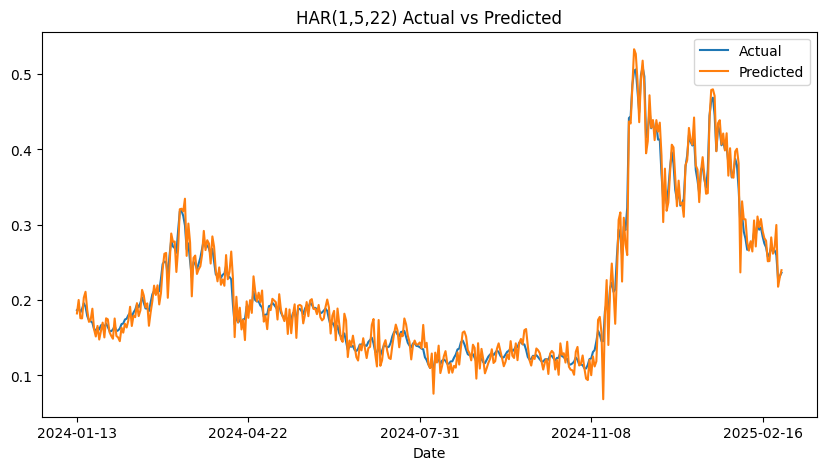

In [12]:
y_pred, y_test = get_pred(df, [1, 5, 22], 1)

# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("HAR(1,5,22) Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=y_pred.index[::100])
plt.legend()


### HAR(1,7,22)

$$
lnRV_t = \alpha + \beta_1 lnRV_{t-1} + \beta_2 lnRV_{7D, t-1} + \beta_3 lnRV_{30D, t-1} + \epsilon_t
$$
Where:
- $lnRV_t$ is the dependent variable (e.g., log realised volatility of return) at time \( t \).
- $\alpha$ is a constant term.
- $\beta_1, \beta_2, \beta_3$ are the coefficients for different time lags.
- $lnRV_{7D, t-1}$ and $lnRV_{30D, t-1}$ are the 1-day lag of the average log realised volatility of return over the past 7 days and 30 days respectively.
- $\epsilon_t$ is the error term.

In [ ]:
# Define dependent (y) and independent variables (X)
y_train = df_train['lnRV']
X_train = df_train[['lnRV_lag1', 'lnRV_7D_lag1', 'lnRV_30D_lag1']]
y_test = df_test['lnRV']
X_test = df_test[['lnRV_lag1', 'lnRV_7D_lag1', 'lnRV_30D_lag1']]

# Add a constant to the independent value
X_train = sm.add_constant(X_train)

# Fit the OLS regression
model = sm.OLS(y_train, X_train).fit()

# Print summary of results
print(model.summary())

In [ ]:
# Predict y values
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

# Save the predicted values
y_pred.to_csv('../res/1D/HAR(1,7,30).csv', index=False)

In [ ]:
# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("HAR(1,7,30) Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=date_ticks)
plt.legend()

# Save the plot
plt.savefig('../res/1D/HAR(1,7,30)_Actual_vs_Predicted.png')

## 3-day ahead forecasting

### HAR(1,5,22)

In [ ]:
# Define dependent (y) and independent variables (X)
y_train = df_train['lnRV']
X_train = df_train[['lnRV_lag3', 'lnRV_5D_lag3', 'lnRV_22D_lag3']]
X_test = df_test[['lnRV_lag3', 'lnRV_5D_lag3', 'lnRV_22D_lag3']]

# Add a constant to the independent value
X_train = sm.add_constant(X_train)

# Fit the OLS regression
model = sm.OLS(y_train, X_train).fit()

# Print summary of results
print(model.summary())

In [ ]:
# Predict y values
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

# Save the predicted values
y_pred.to_csv('../res/3D/HAR(1,5,22).csv', index=False)

# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("HAR(1,5,22) Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=date_ticks)
plt.legend()

# Save the plot
plt.savefig('../res/3D/HAR(1,5,22)_3D_Actual_vs_Predicted.png')

### HAR(1,7,22)

In [ ]:
# Define dependent (y) and independent variables (X)
y_train = df_train['lnRV']
X_train = df_train[['lnRV_lag3', 'lnRV_7D_lag3', 'lnRV_30D_lag3']]
X_test = df_test[['lnRV_lag3', 'lnRV_7D_lag3', 'lnRV_30D_lag3']]

# Add a constant to the independent value
X_train = sm.add_constant(X_train)

# Fit the OLS regression
model = sm.OLS(y_train, X_train).fit()

# Print summary of results
print(model.summary())

In [ ]:
# Predict y values
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

# Save the predicted values
y_pred.to_csv('../res/3D/HAR(1,7,30).csv', index=False)

# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("HAR(1,7,30) Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=date_ticks)
plt.legend()

# Save the plot
plt.savefig('../res/3D/HAR(1,7,30)_3D_Actual_vs_Predicted.png')